In [1]:

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
import torch
import os
from dataloaders.contact_dataset import ContactDataset
from dataloaders.viz_utils import VizUtils

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
from PIL import Image
import cv2

from torch.utils.data import DataLoader, ConcatDataset, random_split

from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual, widgets

import skimage

import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 7.5]


ModuleNotFoundError: No module named 'dataloaders.contact_dataset'

In [ ]:
bag_name = 'stoch_gripper_realenv_EEswap_dynclutt_qsolve_softEE_aligndepthtocolor_depthraw_FTcalib_test_2022-10-17-22-29-38'
dataset_root_dir = os.path.join(os.path.abspath(os.path.join('..')), 'datasets')
dset_path = os.path.join(dataset_root_dir, bag_name)
print(dset_path)
os.path.exists(dset_path)

/home/serialexperimentsleon/courses/cis520/CIS-5200-Final/datasets/stoch_gripper_realenv_EEswap_dynclutt_qsolve_softEE_aligndepthtocolor_depthraw_FTcalib_test_2022-10-17-22-29-38


False

In [ ]:
blur_contact_prob = {
    'enable': True,
    'kernel_size': 5, # in pixels
    'sigma': 0 # if 0, sigma is calculated automatically from kernel size
}


dset = ContactDataset(dset_path, 1, 'EE_object', 
calib_FT=False, im_time_offset=0.1, 
max_depth_clip=2.0, max_num_contact=10, blur_contact_prob_dict=blur_contact_prob, 
contact_persist_time=.0020, 
in_cam_frame=True, im_resize=(180, 320), centered=True)


loaded info dict from pickle file!!


In [111]:
sample_dict = dset[0]

(180, 320)


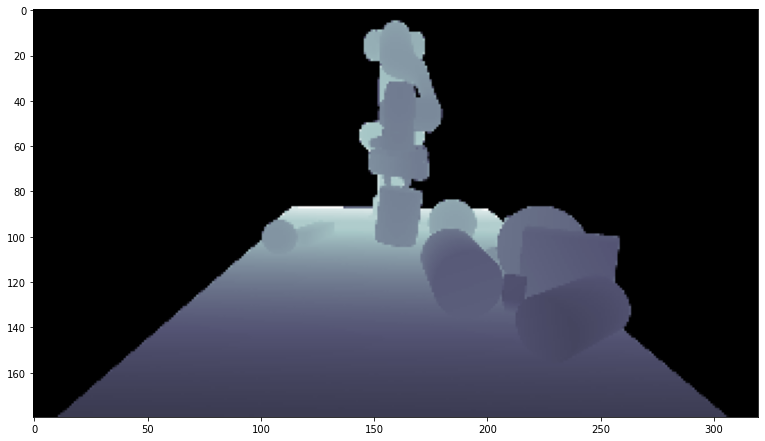

In [112]:
#image tensor returns as (T x H x W)
depth_im = sample_dict['images_tensor'][0, ...]  
print(depth_im.shape)
plt.imshow(dset.tensor_to_depth_im(depth_im, cv2.COLORMAP_BONE)) 


/home/serialexperimentsleon/courses/cis520/CIS-5200-Final/datasets/stoch_gripper_realenv_EEswap_dynclutt_qsolve_softEE_aligndepthtocolor_depthraw_FTcalib_test_2022-10-17-22-29-38/gray/1-118814000000.png


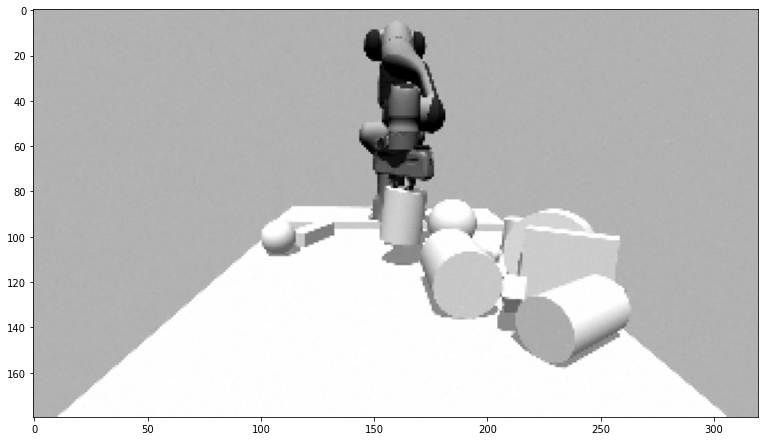

In [113]:
#color_paths returns list of paths of length T
color_im_path = sample_dict['color_paths'][0] 
print(color_im_path)
plt.imshow(dset.color_path_to_im(color_im_path))

In [114]:
dset_loader = DataLoader(
        dset,
        shuffle=False,
        num_workers=4,
        batch_size=8,
        drop_last=False
)

In [115]:
depth_cmap = cv2.COLORMAP_BONE
pred_cmap = cv2.COLORMAP_WINTER
target_cmap = cv2.COLORMAP_HOT

circle_color = cv2.applyColorMap(np.array(255, dtype=np.uint8), target_cmap)[0,0,:].tolist()
circle_dict={'enable': True,
'radius': 15,
'thickness': 1,
'color': circle_color
}

viz_utils = VizUtils(max_depth_clip=2.0, viz_max_depth_clip=1.5, pred_cmap=pred_cmap, target_cmap=target_cmap, image_cmap=depth_cmap,  circle_dict=circle_dict, near_zero_tol=1e-3)


number of contacts:  6
pose (3d position, 4d quaternion):  tensor([ 0.2180,  0.0324,  1.0127,  0.1134, -0.6297, -0.7427, -0.1973],
       dtype=torch.float64)
force-torque wrench (3d force, 3d torque):  tensor([ 12.2444, -18.8333,  -2.0831,  -0.3005,  -0.2713,  -2.1453],
       dtype=torch.float64)


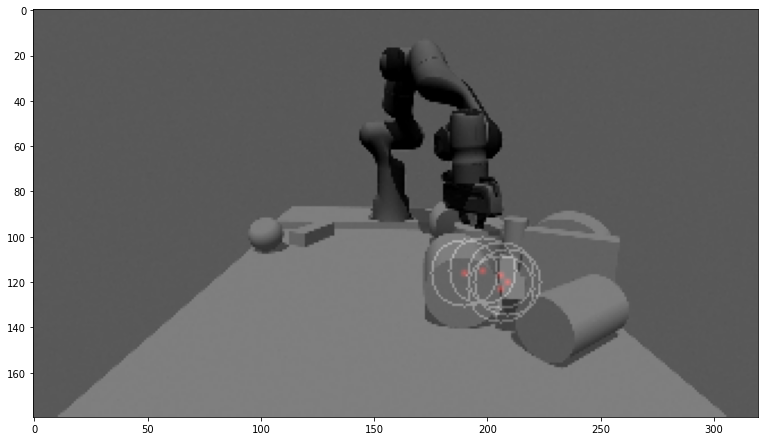

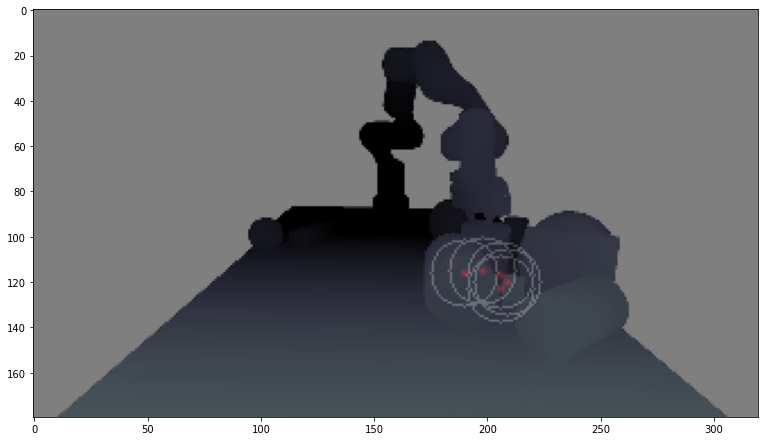

In [116]:
index = 5
for batch_idx, batch_dict in enumerate(dset_loader):
    if batch_idx == index:
        # B x H x W
        # this is the ground truth contact probability map
        # contact pixels are blurred with gaussian kernel as this aids in model training
        target_loc_map_tensor = batch_dict['prob_map_blurred_np'][0, ...].detach().cpu()
        
        # B x T x H x W
        image_tensor = batch_dict['images_tensor'][0, 0, ...].detach().cpu() 
        # T x B
        color_im_path = batch_dict['color_paths'][0][0] 
        contact_pxls_flt = batch_dict['contact_pxls_flt'][0, :]
        print('number of contacts: ', batch_dict['num_contacts'][0].item())
        print('pose (3d position, 4d quaternion): ', batch_dict['poses_np'][0, 0]) # B x T x 7
        print('force-torque wrench (3d force, 3d torque): ', batch_dict['wrenches_np'][0, 0]) # B x T x 6

        heatmap_dict = viz_utils.draw_heatmaps(image_tensor,    
        target_tensor=target_loc_map_tensor,  
        color_path=color_im_path, contact_pxls_flt=contact_pxls_flt)
        
        images = []
        images.append(heatmap_dict['circled_target_color_overlay_im'])
        images.append(heatmap_dict['circled_target_depth_overlay_im'])
        
        for im in images:
            plt.figure()
            plt.imshow(im)
        break
    else:
        pass